In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
import json
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
from tqdm import tqdm
import random

# 데이터 전처리

## google drive import 및 필요 path 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/safedrive_class/
from drive_class import Drive_data_maker

In [ ]:
data_path = '/content/drive/MyDrive/객체인식/data/training'
make_path = '/content/drive/MyDrive/객체인식/new_data/'

drive_data = Drive_data_maker(data_path, make_path)

## Drive_data_maker 실행

In [ ]:
drive_data.all_data_path()

In [ ]:
drive_data.pick_data_path('train_img_path.txt', 'normal', '정상주시')
drive_data.pick_data_path('train_img_path.txt', 'sleep', '졸음재현')
drive_data.pick_data_path('train_img_path.txt', 'phone', '통화재현')

In [ ]:
normal_img_path = drive_data.shuffle_pick('normal_img_path.txt', pick_num=3000)
sleep_img_path = drive_data.shuffle_pick('sleep_img_path.txt', pick_num=3000)
phone_img_path = drive_data.shuffle_pick('phone_img_path.txt', pick_num=3000)

In [ ]:
drive_data.data_split_txt(normal_img_path, sleep_img_path, phone_img_path)

In [ ]:
data_list = ['train', 'valid', 'test']

for data in data_list:
    f = open(make_path + f'{data}.txt', 'r')
    read_data = f.readlines()

    print(len(read_data))

5400
1800
1800


In [ ]:
drive_data.resize_img() # 'mix_data.txt'를 리스트화 시켜 파라미터 값으로 넣어줌

In [ ]:
drive_data.json_path()

In [ ]:
drive_data.json_to_txt()

  0%|          | 0/9000 [00:00<?, ?it/s]

# Darknet 실행을 위한 파일 생성

In [ ]:
f = open('data/ClassNames.names', 'w')

# 문자 입력 (라벨 값)
# f.write("Face"+"\n")
f.write("Closed_Eye\n")
f.write("Opened_Eye\n")
f.write("Face\n")
f.write("Phone")

# 파일 닫기
f.close()

In [ ]:
t = open('data/eyes_data.data', 'w')
t.write("classes = 4\n")
t.write("train = data/train.txt\n")
t.write("valid = data/valid.txt\n")
t.write("test = data/test.txt\n")
t.write("names = data/ClassNames.names\n")
t.write("backup = backup/")
t.close()

# Yolov4 Darknet

In [ ]:
%cd /content/drive/MyDrive/darknet/

/content/drive/MyDrive/darknet


In [ ]:
# Pre-Trained weights 다운 (기존 가중치)

!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
!make

In [ ]:
!./darknet detector train data/eyes_data.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map

# Yolov4 사용

In [ ]:
%cd /content/drive/MyDrive/박한빈1/yolov4/darknet/

/content/drive/MyDrive/박한빈1/yolov4/darknet


In [ ]:
from darknet import *

In [ ]:
# best weight 값 사용
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/eyes_data.data", "backup/yolov4-custom_best.weights")

In [ ]:
width = network_width(network)
height = network_height(network)

In [ ]:
def darknet_helper(img, width, height):
  # 이미지를 darknet style로 전처리 -> darknet_image 변수에 저장
  darknet_image = make_image(width, height, 3)
  # input image를 BRG에서 RGB 순서로 변환
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # input image의 size를 512x512로 변환 (network에서 받아들이는 이미지의 크기가 512x512였기 때문에)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # bounding box의 크기를 조정하기 위하여 이미지 크기 비율을 계산 
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width # 원본 이미지 width/ network width
  height_ratio = img_height/height # 원본 이미지 height/ network height

  # darknet stlye로 전처리된 이미지로 모델을 작동시켜 detection을 수행
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  # detect_image 함수 실행
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)

  return detections, width_ratio, height_ratio

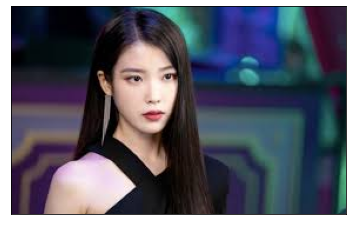

In [ ]:
# 이미지 불러오기
image = cv2.imread('/content/drive/MyDrive/jmw.jpg')
#RGB 이미지를 BGR로 변환
imagee = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# 이미지 출력
plt.imshow(imagee) 
plt.xticks([]) # x축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.yticks([]) # y축 눈금 (빈칸으로 두어 아무것도 표기되지 않도록 함)
plt.show() 

In [ ]:
detections, width_ratio, height_ratio = darknet_helper(imagee, width, height)
detections, width_ratio, height_ratio

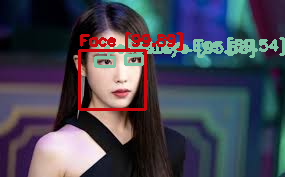

In [ ]:
# detection 결과 시각화

for label, confidence, bbox in detections:
  # center x, center y, width, height로 반환 받은 boundary box를 corner 정보 (left, top, right, bottom)로 변환
  left, top, right, bottom = bbox2points(bbox)
  # 앞서 계산한 이미지 비율을 사용하여 boundary box의 크기를 조정
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  # boundary box 좌표에 해당하는 사각형을 이미지 위에 그림
  cv2.rectangle(imagee, (left, top), (right, bottom), class_colors[label], 2)
  # 클래스 이름과 confidence level을 사각형 위에 입력
  cv2.putText(imagee, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

# boundary box를 추가한 이미지 출력
#RGB 이미지를 BGR로 변환
image = cv2.cvtColor(imagee, cv2.COLOR_RGB2BGR)
cv2_imshow(image)

# 웹캠 사용을 위한 Helper Functions 생성

In [ ]:
# JavaScript 객체를 OpenCV 이미지 유형으로 변환
def js_to_image(js_reply):
  """
  파라미터:
          js_reply: JavaScript 객체 (Base64 진법의 문자열)
  반환:
          img:  OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  """

  # 64진법으로 인코딩된 Javascript 객체를 바이트로 디코딩 
  image_bytes = b64decode(js_reply.split(',')[1])
  # 바이트를 넘파이 배열로 변환
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 넘파이 배열을 OpenCV BGR 이미지로 변환
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
# OpenCV 사각형(Bounding Box) 이미지를 JavaScript 객체로 변환
def bbox_to_bytes(bbox_array):
  """
  파라미터:
          bbox_array: OpenCV BGR 이미지 (넘파이 배열로 이루어진 사각형 정보) 
  반환:
        바이트: JavaScript 객체 (Base64 진법의 문자열)
  """
  # 넘파일 배열을 PIL(Python Image Library) 이미지로 변환 
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  # 문자열(바이트 배열)을 이진 파일로 읽을 수 있는 BytesIO 객체 생성
  iobuf = io.BytesIO()
  # PIL 이미지 형태의 boundary box를 png 파일로 변환하여 저장 
  bbox_PIL.save(iobuf, format='png')
  # JavaScript 객체 반환
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# 웹캠

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):

  # 자바스크립트를 사용하여 local webcam에 access 
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // 결과를 resize
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // 클릭하여 이미지 캡쳐
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # YOLO v4 detection 수행

  # javascrip 이미지를 입력
  data = eval_js('takePhoto({})'.format(quality))
  # OpenCV 형식의 이미지로 변환
  img = js_to_image(data) 
  
  # 앞서 정의했던 darknet helper 함수에 웹캠 이미지를 삽입
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # detection을 통해 얻은 boundary boxes를 웹캠 이미지에 표시
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # 이미지를 저장
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  # 앞서 정의한 take_photo 함수를 실행
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # take photo 결과물을 출력
  display(Image(filename))

  # 에러가 발행했을 실행
except Exception as err:
  # 사용자의 컴퓨터에 웹캠이 없거나 웹캠 접근권한이 없을 때 에러 메시지를 출력
  print(str(err))

# 웹캠 비디오 실행

In [ ]:
# 실시간 영상 스트리밍을 작동시키는 JavaScript 코드
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# 웹캠에서 영상 스트리밍을 시작
video_stream()
# label for video
label_html = 'Capturing...'
# bounding box 초기화 
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # javascript 객체를 OpenCV 이미지로 변환 
    frame = js_to_image(js_reply["img"])

    # bounding box를 위한 투명 overlay 생성
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # 앞서 정의하였던 darknet helper 함수를 실행 
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # detection 결과를 순회하며 결과를 overlay 이미지에 표시
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # bounding box의 overlay를 바이트로 변환
    bbox_bytes = bbox_to_bytes(bbox_array)
    # bounding box를 업데이트하여 다음 프레임이 새로운 overlay를 갖도록 함
    bbox = bbox_bytes

<IPython.core.display.Javascript object>